In [1]:
import numpy as np
import lhsmdu
import matplotlib.pyplot as plt
import sys
import os
from scipy import stats
%matplotlib inline 
sys.path.append('./pytools/')
from pytools import test, p_pce_bcs, model_inf

./pytools/pytools.py:146: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(nx == ny, 'Check the size of X and Y!!!')
./pytools/pytools.py:147: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(nm == nf, 'Cehck the size of PC data!!!')


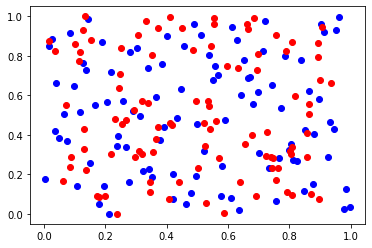

In [2]:
# See differences between uniform random numbers and Latin Hypercube Sampling
l = lhsmdu.sample(11,100)
u = np.random.uniform(low=0,high=1,size=((11,100)))
plt.plot(l[0,:],l[1,:],'bo')
plt.plot(u[0,:],u[1,:],'ro')


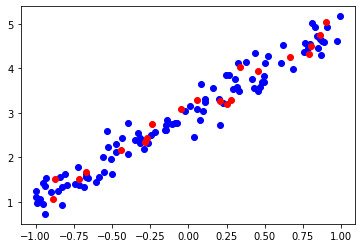

In [3]:
# Create training data from linear model: y = 2 * x + 3 + noise
# y represents model outputs
# x represents model inputs/parameters
ntrain = 100 # number of training simulations
nval   = 20  # number of validating simulations
xtrain = np.random.uniform(low=-1,high=1,size=(ntrain,1))                  # samples for inputs/parameters
ytrain = 2*xtrain + 3 + np.random.normal(loc=0,scale=0.25,size=(ntrain,1)) # simulations 
xval = np.random.uniform(low=-1,high=1,size=(nval,1))
yval = 2*xval + 3 + np.random.normal(loc=0,scale=0.25,size=(nval,1))
xobs = 0.7         
yobs = 2*xobs + 3  # observation data
plt.plot(xtrain,ytrain,'bo')
plt.plot(xval,yval,'ro')

In [4]:
# Setup UQTk parameters 
pars = dict()
pars['pc_type']   = 'LU'
pars['in_pcdim']  = 1
pars['out_pcord'] = 3
pars['pred_mode'] = 'ms'
pars['tol']       = 1e-5

# Change this to where you install UQTk
uqtkbin = '/Users/xudo627/projects/UQTk/UQTk-install/bin/'

************ Trainning Surrogate Model ************
##################################################
-------------------- 0th QOI --------------------
Running /Users/xudo627/projects/UQTk/UQTk-install/bin/gen_mi -x"TO" -p 3 -q1 > gmi.log
Running /Users/xudo627/projects/UQTk/UQTk-install/bin/regression -x xdata.dat -y ydata.dat -b PC_MI -s LU -p mi.dat -w regparams.dat -m ms -r wbcs -t xcheck.dat -c 1e-05 > regr.log
Evaluating surrogate at 100 training points
Running pce_eval -x'PC_mi' -f'pccf.dat' -sLU -r'mindex.dat' > fev.log
Surrogate relative error at training points : [0.08124173]
Evaluating surrogate at 20 validating points
Running pce_eval -x'PC_mi' -f'pccf.dat' -sLU -r'mindex.dat' > fev.log
Surrogate relative error at validating points : [0.0554029]


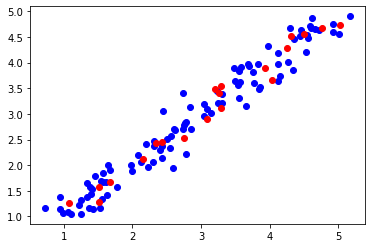

In [5]:
# Train PCE-based surrogate model with Bayesian Compressing Sensing technique
ytrain_pc, yval_pc, pccf_all, mindex_all = p_pce_bcs(uqtkbin,pars,xtrain,ytrain,xval,yval,1,os.getcwd(),1)
# Plot the comparision between surrogates and "actual" model
plt.plot(ytrain,ytrain_pc,'bo')
plt.plot(yval,yval_pc,'ro')

In [6]:
# Parameter inference with MCMC given observation data
mapp, pchain = model_inf(uqtkbin, None, yobs*np.ones((1,1)), pars, mindex_all, pccf_all, 0, cur_dir, 1)

Running /Users/xudo627/projects/UQTk/UQTk-install/bin/model_inf -f pcs -l classical -a -1 -b 1 -d 1 -m 10000 -o 3 > inference.log


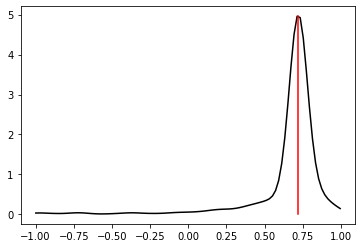

In [7]:
# Plot the posterior of the parameter 
kde = stats.gaussian_kde(pchain[:,0])
x = np.linspace(pchain[:,0].min(), pchain[:,0].max(), 100)
p = kde(x)
plt.plot(x,p,'k-')
plt.plot([mapp[0],mapp[0]],[np.min(p),np.max(p)],'r-')